In [7]:
path = ""

In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# A Statistical Analysis of Northwestern University's Football Success

In preparation for the Wildcats' debut in the BigTen Championship, I thought it would be interesting to take a step back and try to understand the team's performance this season. Some will argue that Northwestern simply had a slow start with QB Clayton Thorson sidelined for much of the summer with an ACL tear. This does not, however, explain our win against Purdue in our season opener, so I wanted to search for a less obvious, more powerful factor that could explain Northwestern's dominant wins against ranked opponents and devastating losses against schools like Akron and Duke.

As it is Thanksgiving break and I'm not interested in building a conventional CFB prediction algorithm from scratch, I will be using the over/under as documented by https://news.sportsinteraction.com/ as the baseline for comparing the power of new models

In [47]:
over_under = pd.read_csv(path+"over_under.csv",index_col="Team")
over_under

,Spread,Win
Team,,
Purdue,-6.5,1
Duke,-2.5,0
Akron,-21.0,0
Michigan,14.5,0
MSU,10.5,1
Nebraska,-3.0,1
Rutgers,-21.0,1
Wisconsin,4.5,1
ND,7.5,0


Let's see what happens when we plot the spread against victories

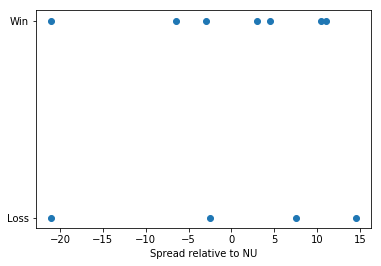

In [134]:
win = ["Loss" if game==0 else "Win" for game in over_under.Win] 
plt.scatter(over_under.Spread, win)
plt.xlabel("Spread relative to NU")
plt.gca().invert_yaxis()
plt.show()

How effectively could the probability of winning be modeled by a sigmoidal equation using this data?

In [137]:
X_train = over_under.Spread.values.reshape(-1,1)
y_train = over_under.Win.values
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
print("Training accuracy: ",clf.score(X_train,y_train))

Training accuracy:  0.6363636363636364


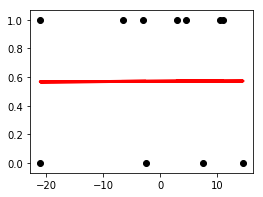

In [138]:
def model(x):
    return 1 / (1 + np.exp(-x))

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X_train.ravel(), y_train, color='black', zorder=20)

loss = model(X_train * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_train, loss, color='red', linewidth=3)
plt.show()

Clearly Las Vegas does not have a very effective algorithm for predicting games.

Now lets try using less conventional predictors and see how they fare. Spefically, school colors!

In [146]:
colors = pd.read_csv(path+'colors.csv',index_col="Team")
colors

,Black,White,Grey,Red,Yellow,Green,Blue,Win
Team,,,,,,,,
Purdue,1,0,0,0,1,0,0,1
Duke,0,1,0,0,0,0,1,0
Akron,0,0,0,0,1,0,1,0
Michigan,0,0,0,0,1,0,1,0
MSU,0,1,0,0,0,1,0,1
Nebraska,0,1,1,1,0,0,0,1
Rutgers,1,0,1,1,0,0,0,1
Wisconsin,0,1,0,1,0,0,0,1
ND,0,0,0,0,1,0,1,0


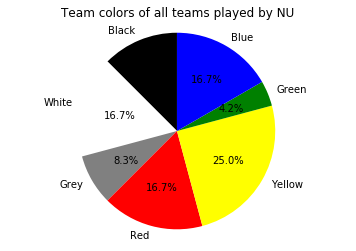

In [153]:
labels = 'Black', 'White', 'Grey', 'Red','Yellow','Green','Blue'
sizes = [sum(colors.Black),sum(colors.White),sum(colors.Grey),sum(colors.Red),sum(colors.Yellow),sum(colors.Green),sum(colors.Blue)]
pie_colors = ['black', 'white', 'grey', 'red','yellow','green','blue']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Team colors of all teams played by NU")
plt.show()

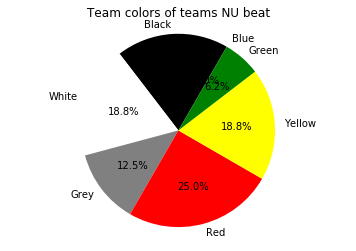

In [158]:
wins = colors.loc[colors.Win==1]
labels = 'Black', 'White', 'Grey', 'Red','Yellow','Green','Blue'
sizes = [sum(wins.Black),sum(wins.White),sum(wins.Grey),sum(wins.Red),sum(wins.Yellow),sum(wins.Green),sum(wins.Blue)]
pie_colors = ['black', 'white', 'grey', 'red','yellow','green','blue']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        colors=colors, startangle=60)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Team colors of teams NU beat")
plt.show()

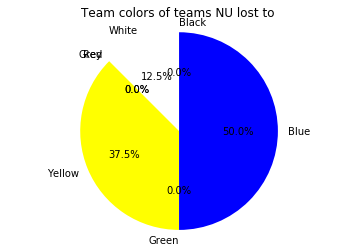

In [159]:
losses = colors.loc[colors.Win==0]
labels = 'Black', 'White', 'Grey', 'Red','Yellow','Green','Blue'
sizes = [sum(losses.Black),sum(losses.White),sum(losses.Grey),sum(losses.Red),sum(losses.Yellow),sum(losses.Green),sum(losses.Blue)]
pie_colors = ['black', 'white', 'grey', 'red','yellow','green','blue']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Team colors of teams NU lost to")
plt.show()

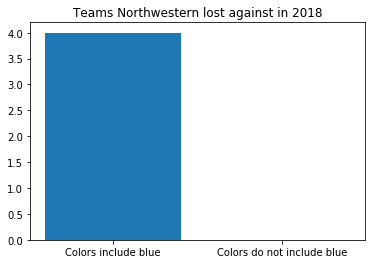

In [160]:
losses = colors.loc[colors.Win==0]
blue_count = len(losses.loc[losses.Blue==1])
not_blue_count = len(losses.loc[losses.Blue!=1])

plt.bar(x=["Colors include blue","Colors do not include blue"],height=[blue_count,not_blue_count])
plt.title("Teams Northwestern lost against in 2018")
plt.show()

There it is: Northwestern's secret weakness is the color blue. Lets try buiding a model around this

In [164]:
X_train = colors[["Black","White","Grey","Red","Yellow","Green","Blue"]].values
y_train = colors.Win.values

clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
print("Logistic regression training accuracy using all colors: ",clf.score(X_train,y_train))
#Black, White, Grey, Red, Yellow, Green, Blue
OSU = np.matrix([0,0,1,1,0,0,0])
UM = np.matrix([0,0,0,0,1,0,1])

print("Odds of beating Ohio State in the Big10 championship: ",round(clf.predict_proba(OSU)[0][1],2),"%")
print("Odds of beating Michigan in the Big10 championship: ",round(clf.predict_proba(UM)[0][1],2),"%")

Logistic regression training accuracy using all colors:  1.0
Odds of beating Ohio State in the Big10 championship:  0.89 %
Odds of beating Michigan in the Big10 championship:  0.22 %


In [167]:
X_train = colors.Blue.values.reshape(-1,1)
y_train = colors.Win.values

clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
print("Training accuracy based entirely on the color blue: ",clf.score(X_train,y_train))

OSU = np.matrix([0])
UM = np.matrix([1])

print("Odds of beating Ohio State in the Big10 championship: ",round(clf.predict_proba(OSU)[0][1],2),"%")
print("Odds of beating Michigan in the Big10 championship: ",round(clf.predict_proba(UM)[0][1],2),"%")

Training accuracy based entirely on the color blue:  1.0
Odds of beating Ohio State in the Big10 championship:  0.83 %
Odds of beating Michigan in the Big10 championship:  0.3 %
